In [1]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from DanceProj1.XGB_Genreclass import get_XGBclassifier
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features
import matplotlib.pyplot as plt

This notebook is for inspecting the model, focusing on XGBoost, which worked best. get_XGBclassifier essentially does everything from Notebook 02 (see XGB_Genreclass.py)

In [2]:
xgb_mod, X_test, y_test, y_pred, y_proba_pred, yprobdf = get_XGBclassifier()

there were index errors on 0 dances


Having trained on ~1200 Basic sequences and ~100 advanced sequences, XGBoost can perform at about 70%

In [3]:
print('XGBoost Score =',xgb_mod.score(X_test, y_test))

XGBoost Score = 0.7184466019417476


The dataframe yprobdf contains the probability estimates for every sequence in the test set, plus the true label of that sequence

In [4]:
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.881912,0.047841,0.000755,0.009659,0.003028,0.039919,0.001684,0.003520,0.009551,0.002129,1202,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.872340,0.002356,0.001486,0.005623,0.002907,0.042617,0.002248,0.011095,0.043920,0.015407,1215,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.527617,0.005418,0.001452,0.002075,0.002232,0.022762,0.000993,0.005668,0.027847,0.403935,1205,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.992875,0.000747,0.000963,0.000064,0.000992,0.000196,0.000848,0.000236,0.001841,0.001240,1209,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.647217,0.002038,0.000705,0.002782,0.001083,0.027255,0.001199,0.003232,0.030318,0.284171,1201,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [5]:
genres = yprobdf['True_Label'].unique()
X_truegenre = {}
X_guessgenre = {}
for i, genre in enumerate(genres):
    X_truegenre[genre] = X_test[y_test == i]
    X_guessgenre[genre] = X_test[y_pred == i]


print('number of House pieces, features for each:', X_truegenre['House'].shape)
print('number of House guesses, features for each:', X_guessgenre['House'].shape)

number of House pieces, features for each: (11, 17)
number of House guesses, features for each: (7, 17)


Below is the confusion matrix, which shows the numer of correct classifications for each genre and shows what each genre was misclassified as, on how many occasions

<Figure size 700x700 with 0 Axes>

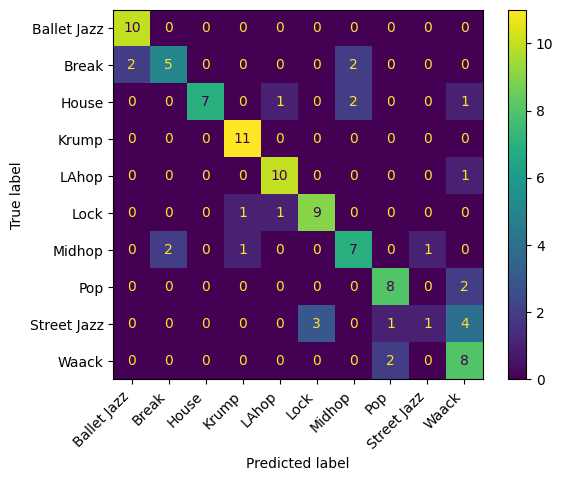

In [6]:
#inspect confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_test, y_test)
#change xticks and yticks to labels

labels = yprobdf['True_Label'].unique()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels, rotation=45, ha='right')
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels)
plt.savefig('../plots/XGBconfusionmatrix.png')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


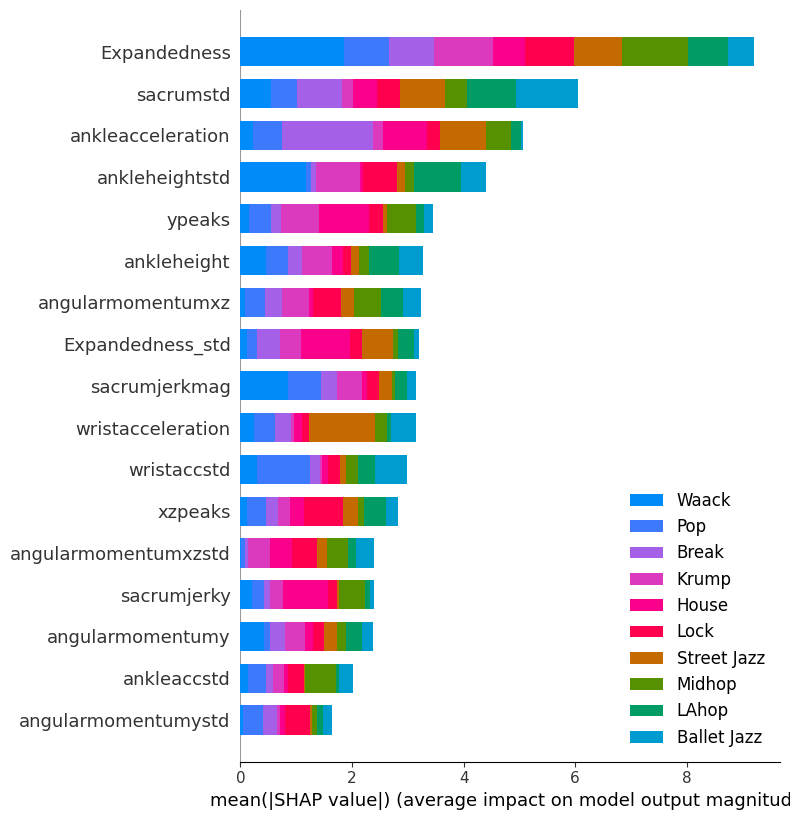

<Figure size 640x480 with 0 Axes>

In [7]:
#shapley
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X_test, y_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=labels, title='Shapley Summary Plot')
plt.savefig('../plots/XGBshapsummaryFull.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


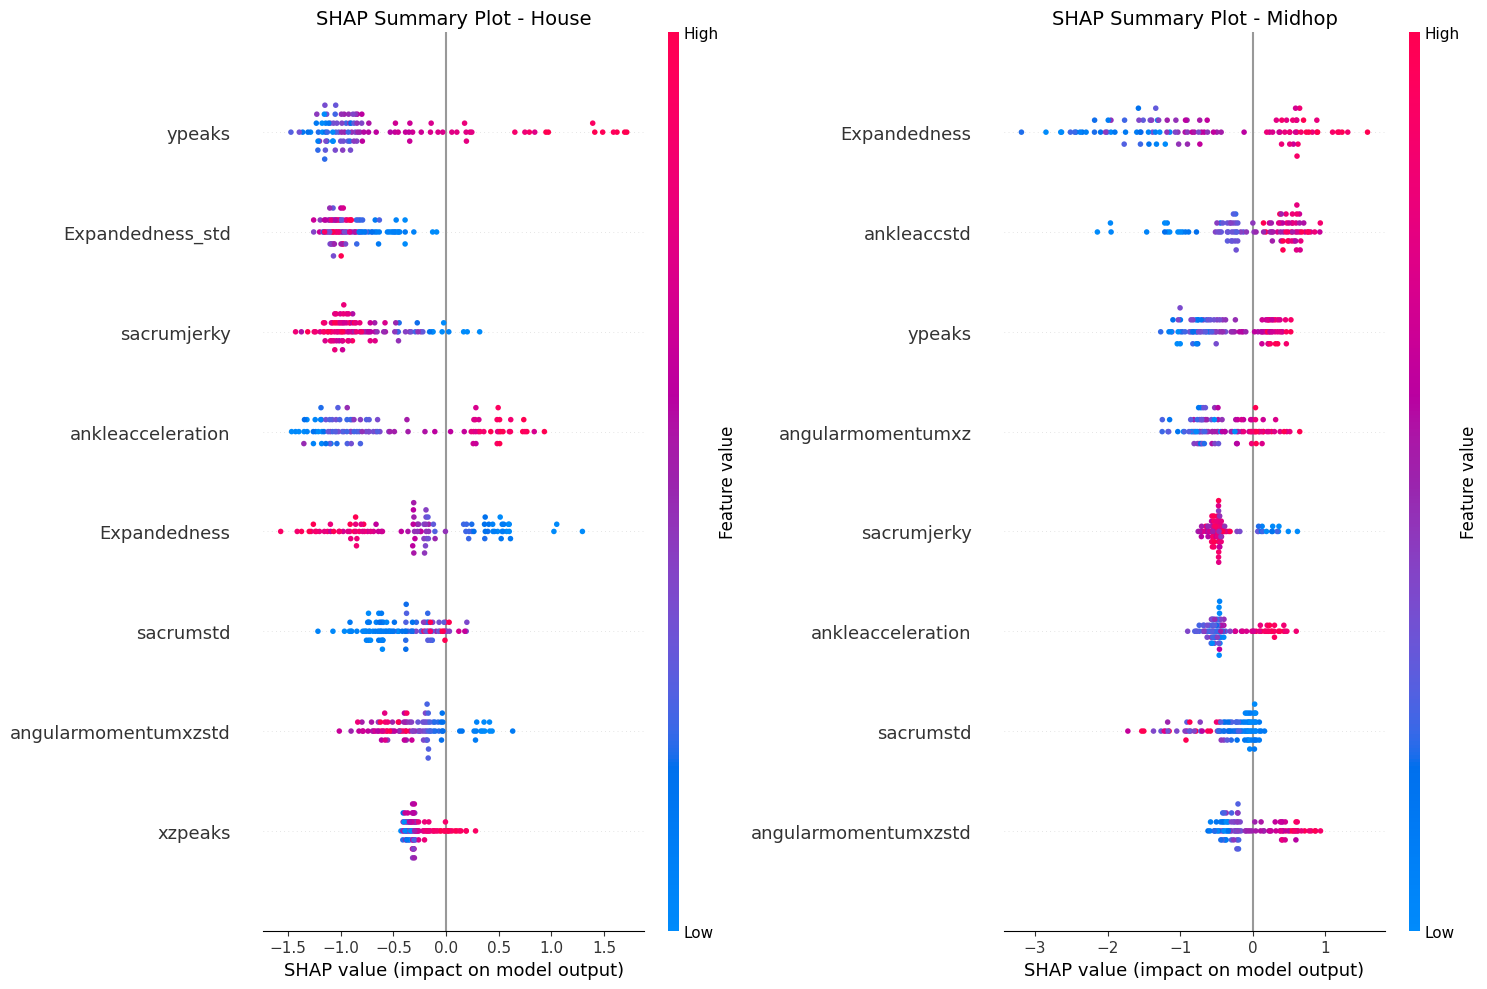

In [8]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(1, 2)

for i, genre in enumerate(['House', 'Midhop']):
    ax = plt.subplot(gs[i])
    shap.summary_plot(shap_values[list(genres).index(genre)], X_test, max_display=8, show=False, plot_size=None)
    ax.set_title(f'SHAP Summary Plot - {genre}', fontsize=14)

plt.tight_layout()
plt.show()

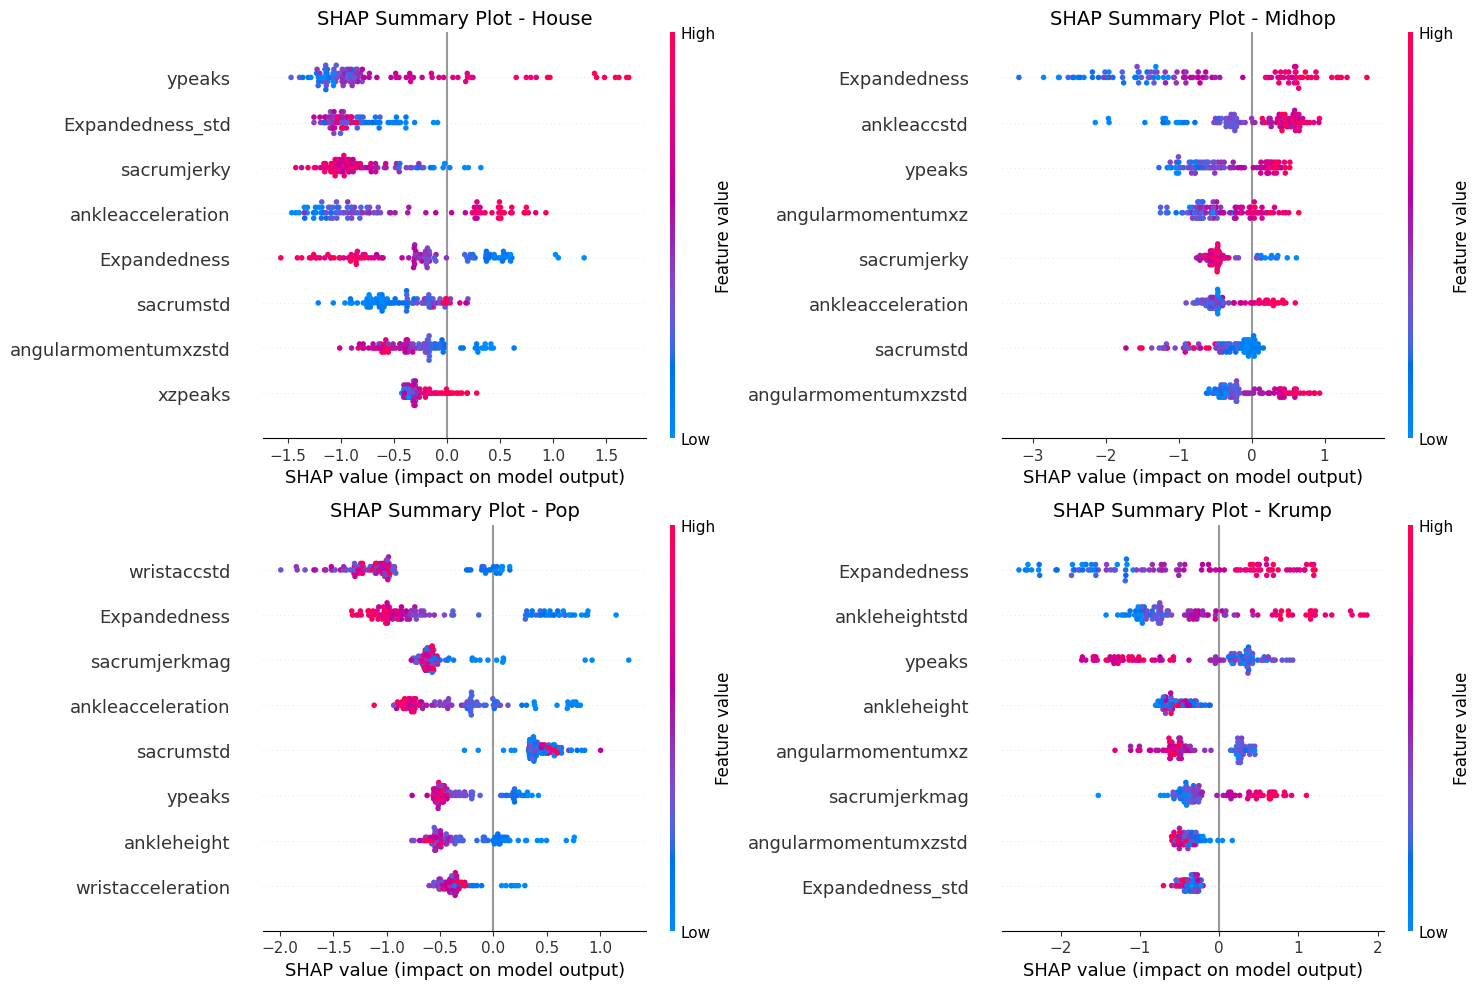

In [9]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)

for i, genre in enumerate(['House', 'Midhop', 'Pop', 'Krump']):
    ax = plt.subplot(gs[i])
    shap.summary_plot(shap_values[list(genres).index(genre)], X_test, max_display=8, show=False, plot_size=None)
    ax.set_title(f'SHAP Summary Plot - {genre}', fontsize=14)

plt.tight_layout()
plt.show()



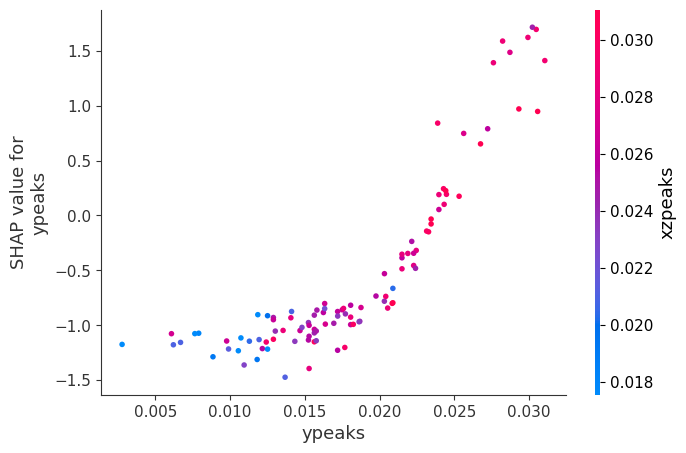

In [10]:
#shape dependence plot, ypeaks House
shap.dependence_plot('ypeaks', shap_values[list(genres).index('House')], X_test, interaction_index='xzpeaks')

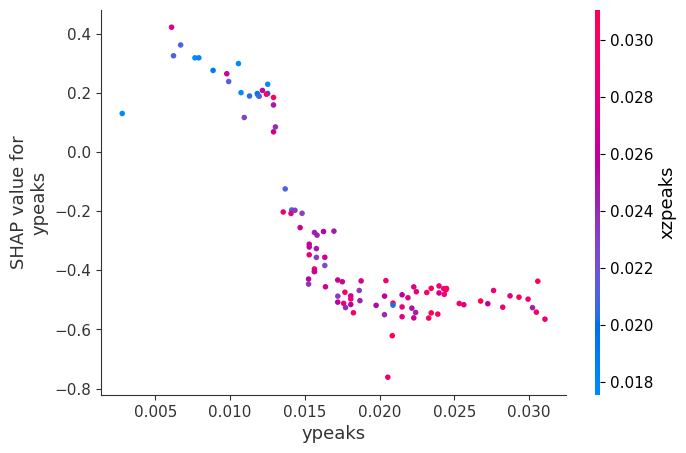

In [11]:
#shape dependence plot, ypeaks Break
shap.dependence_plot('ypeaks', shap_values[list(genres).index('Pop')], X_test, interaction_index='xzpeaks')

In [12]:
xgb_mod.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

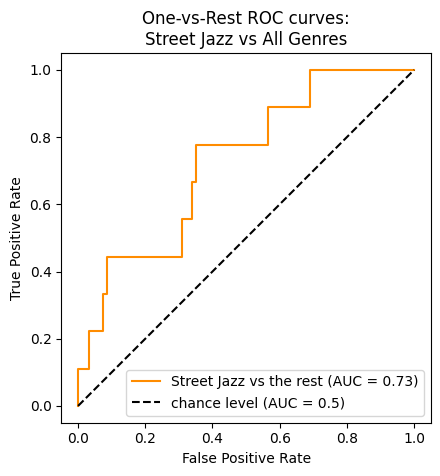

In [13]:
#roc curve, Genre vs all genres
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

labels = yprobdf['True_Label'].unique()
genre_mapping = {0: 'Ballet Jazz', 1: 'Break', 2: 'House', 3: 'Krump', 4: 'LAhop', 5: 'Lock', 6: 'Midhop', 7: 'Pop', 8: 'Street Jazz', 9: 'Waack'}

def map_labels_to_genres(labels, mapping):
    return [mapping[label] for label in labels]

# Transform the y_test labels back to genre names
y_test_genres = map_labels_to_genres(y_test, genre_mapping)

# Use the genre names with the LabelBinarizer
label_binarizer = LabelBinarizer().fit(list(genre_mapping.values()))
y_onehot_test = label_binarizer.transform(y_test_genres)

class_of_interest = "Street Jazz"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_proba_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nStreet Jazz vs All Genres")
plt.legend()
plt.show()

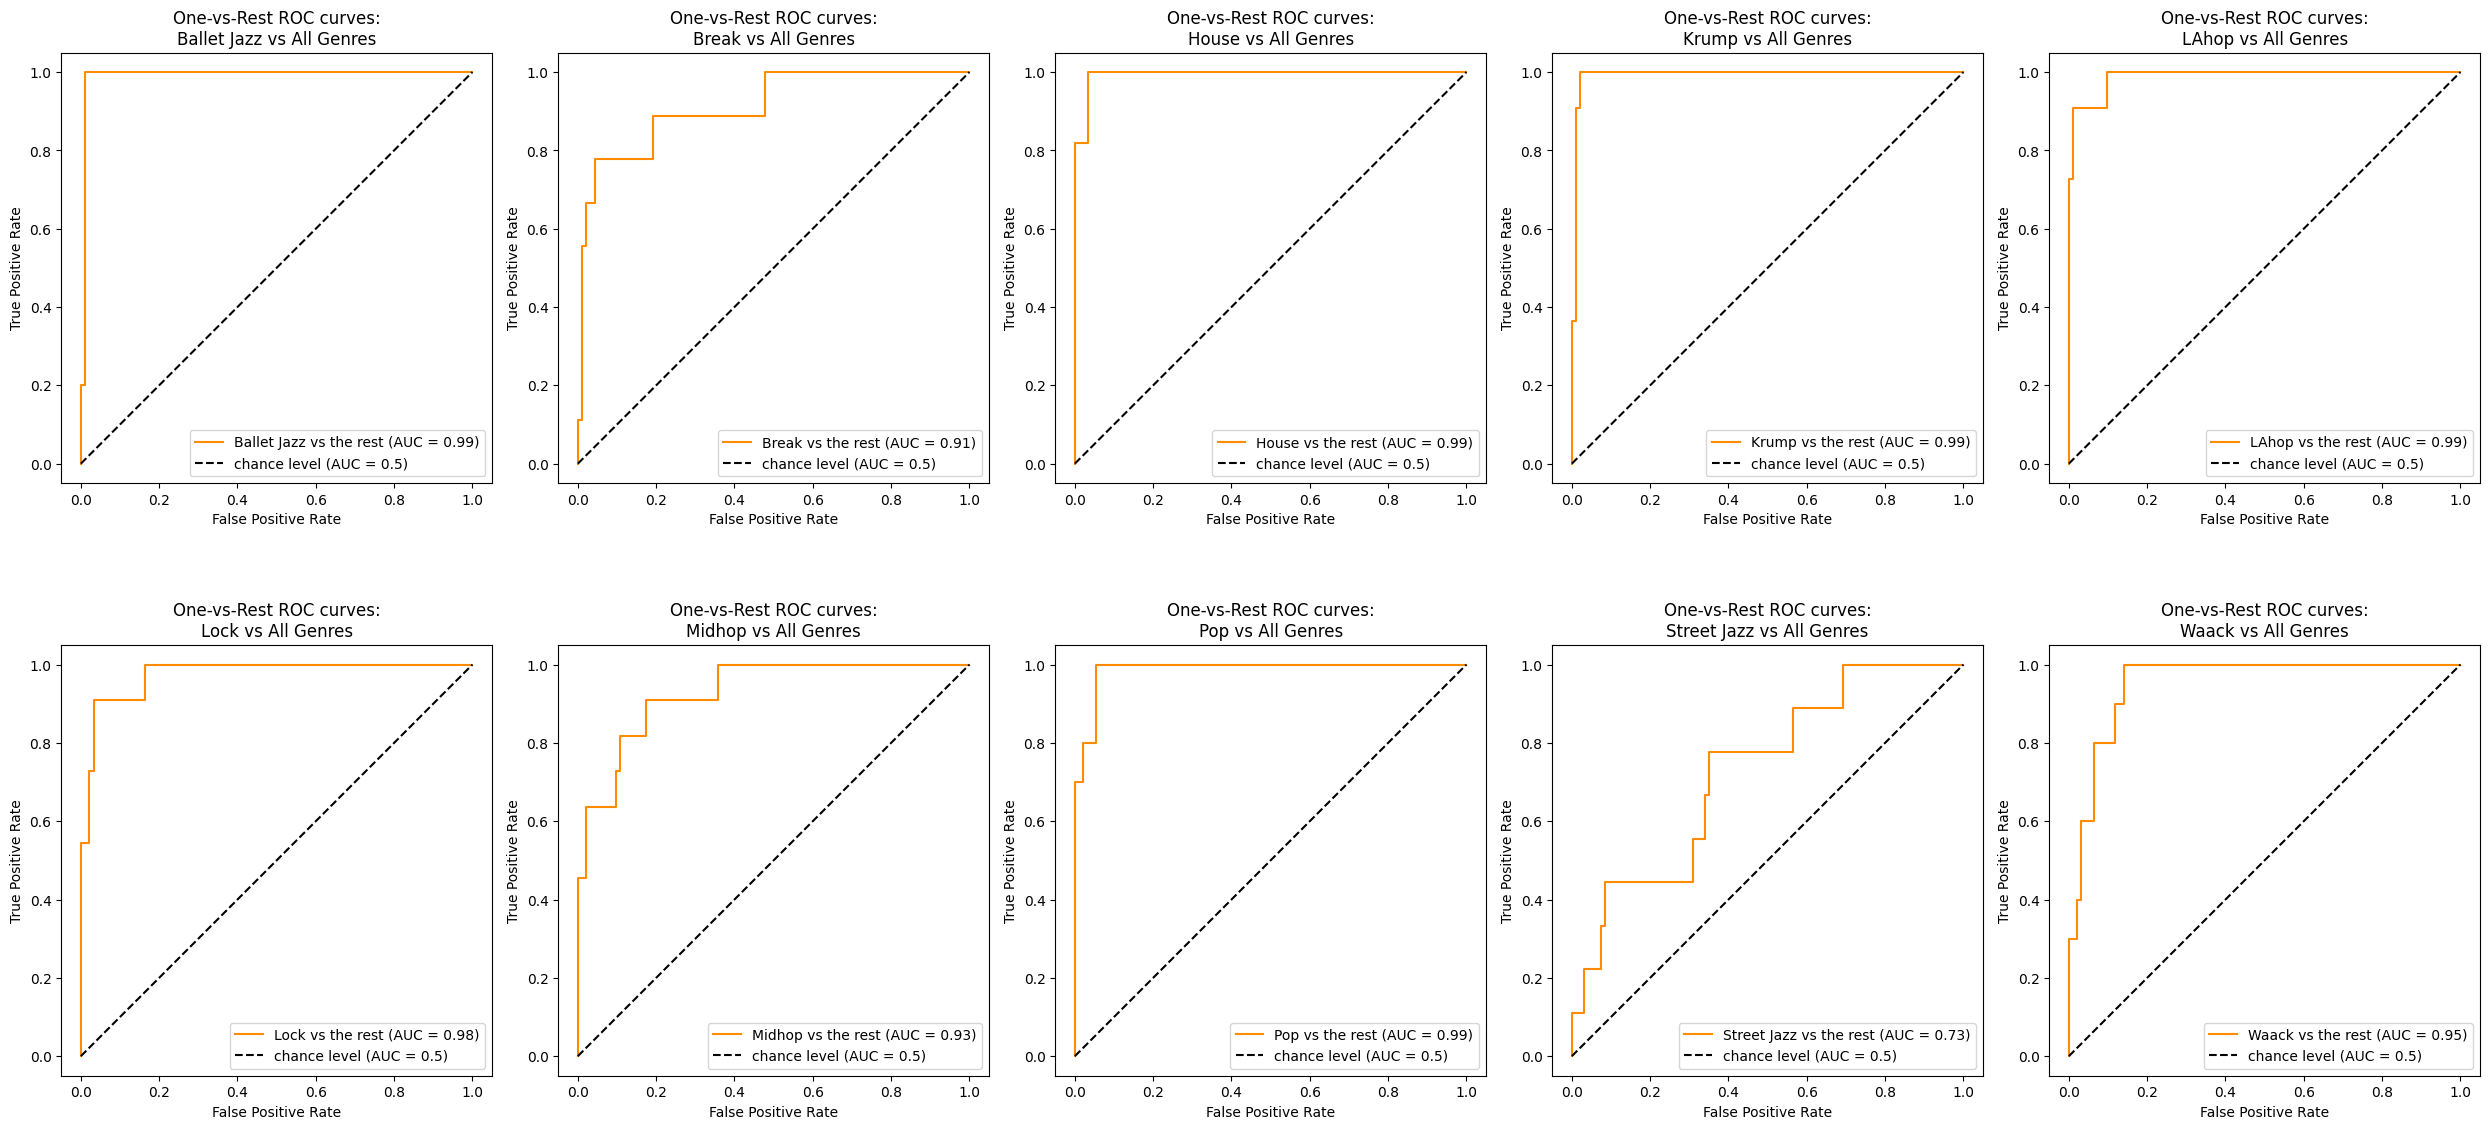

In [14]:
#roc curves, 2 by five figure of each genre vs all genres
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


labels = yprobdf['True_Label'].unique()
genre_mapping = {0: 'Ballet Jazz', 1: 'Break', 2: 'House', 3: 'Krump', 4: 'LAhop', 5: 'Lock', 6: 'Midhop', 7: 'Pop', 8: 'Street Jazz', 9: 'Waack'}

def map_labels_to_genres(labels, mapping):
    return [mapping[label] for label in labels]

# Transform the y_test labels back to genre names
y_test_genres = map_labels_to_genres(y_test, genre_mapping)

# Use the genre names with the LabelBinarizer
label_binarizer = LabelBinarizer().fit(list(genre_mapping.values()))
y_onehot_test = label_binarizer.transform(y_test_genres)

fig, axes = plt.subplots(2, 5, figsize=(25, 12))
axes = axes.ravel()

for idx, genre in enumerate(labels):
    class_id = np.flatnonzero(label_binarizer.classes_ == genre)[0]
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_proba_pred[:, class_id],
        name=f"{genre} vs the rest",
        color="darkorange",
        ax=axes[idx]
    )
    axes[idx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axes[idx].axis("square")
    axes[idx].set_xlabel("False Positive Rate")
    axes[idx].set_ylabel("True Positive Rate")
    axes[idx].set_title(f"One-vs-Rest ROC curves:\n{genre} vs All Genres")
    axes[idx].legend()


plt.tight_layout()
plt.show()
    

Get Dataframes of the features of all dances in the test set

In [15]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dfBM, dfFM = data_to_features(dataBM, dataFM)  #get features

#alphabetize dfs by genre (to avoid reordering by classifiers later)
# dfFM = dfFM.sort_values(by='Genre')

# #make new indexes for Advanced, starting after last index in Basic, for unique index per id
# #this is so that Basic and Adv indexes dont overlap.
# dfFM.index = range(len(dfBM.index), len(dfBM.index)+len(dfFM.index))

there were index errors on 0 dances


In [16]:
#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfFM_scaled = pd.DataFrame(scaler.fit_transform(dfFM.drop(['Genre', 'id'], axis=1)), columns=dfFM.drop(['Genre', 'id'], axis=1).columns)
dfBM_scaled = pd.DataFrame(scaler.fit_transform(dfBM.drop(['Genre', 'id'], axis=1)), columns=dfBM.drop(['Genre', 'id'], axis=1).columns)

dfFM_scaled['Genre'] = dfFM['Genre']
dfBM_scaled['Genre'] = dfBM['Genre']

dfFM_scaled.head()

,sacrumstd,sacrumjerkmag,sacrumjerky,angularmomentumxz,angularmomentumy,angularmomentumxzstd,angularmomentumystd,ypeaks,xzpeaks,wristacceleration,wristaccstd,ankleacceleration,ankleaccstd,ankleheight,ankleheightstd,Expandedness,Expandedness_std,Genre
0,0.289450,0.377183,-1.680877,-0.990355,1.654307,1.599398,0.365944,0.384263,0.566484,1.013880,0.508676,0.774147,1.790028,0.440852,2.174497,0.851939,0.027460,Break
1,-0.433074,1.828873,0.612959,0.014673,1.373518,1.650490,0.453739,0.654273,-0.096962,1.008204,0.842316,1.515609,1.919456,0.233464,1.328596,1.593847,0.498825,Break
2,0.003795,0.713917,-0.084789,-0.584464,1.692504,0.432021,0.586774,1.261536,0.362586,0.529937,0.138761,0.721439,0.114426,0.245286,0.034895,0.095588,0.307366,Break
3,-0.231732,0.311704,0.613299,-0.583028,0.518722,1.050867,2.015175,0.727369,0.555427,0.142785,0.294054,1.193813,1.215395,0.362207,-0.107130,1.269722,0.498282,Break
4,-0.231958,1.442530,-0.621055,-1.420997,1.104173,1.099030,1.302600,0.749794,0.668433,1.621241,0.745819,1.829354,1.029125,1.010442,0.190844,1.312218,0.322649,Break


Get a dataframe / matrix where rows = features and columns = genre, values are average of each feature by genre

In [ ]:
#make df of features by genre
features = dfFM_scaled.columns.drop('Genre')
featuresdf = pd.DataFrame(columns=dfFM_scaled['Genre'].unique(), index=features)
#remove genre row

for i, feature in enumerate(features):
    for genre in dfFM_scaled['Genre'].unique():
        featuresdf.iloc[i][genre] = dfFM_scaled[feature][dfFM_scaled['Genre']==genre].mean()

# z scale columns of featuresdf
featuresdf_norm = featuresdf.to_numpy()

featuresdf_norm = pd.DataFrame(featuresdf_norm, columns=featuresdf.columns, index=featuresdf.index)
featuresdf_norm.head()

In [20]:
genresbyfeatures = featuresdf_norm.to_numpy().T
genresbyfeatures = pd.DataFrame(genresbyfeatures, columns=featuresdf_norm.index, index=featuresdf_norm.columns)
genresbyfeatures.head()

,sacrumstd,sacrumjerkmag,sacrumjerky,angularmomentumxz,angularmomentumy,angularmomentumxzstd,angularmomentumystd,ypeaks,xzpeaks,wristacceleration,wristaccstd,ankleacceleration,ankleaccstd,ankleheight,ankleheightstd,Expandedness,Expandedness_std
Break,0.199033,1.208798,0.138279,-0.352938,1.402697,1.125636,1.361781,0.60217,0.29867,0.836176,0.601035,1.393349,1.414797,1.344436,1.394687,0.895712,0.572853
Pop,-0.361071,-1.384713,0.354042,0.12128,-0.392985,-1.0188,-0.737484,-1.371617,-1.121477,-1.65066,-1.632486,-1.141489,-1.177907,-0.989773,-0.634298,-0.252215,-0.413312
Lock,-0.51758,0.001889,0.313269,-0.550309,0.067795,-0.568343,-0.551993,-0.40329,-0.290347,-0.327899,-0.196029,-0.324568,-0.248747,-0.197336,0.085894,-0.474768,-0.362518
Midhop,-0.15296,1.076071,-0.52211,0.66324,0.698466,0.820253,-0.019751,0.936207,0.676252,0.630503,0.229648,0.769077,0.701294,0.264585,0.090823,1.020043,0.044947
LAhop,-0.524207,-0.382676,-0.060426,-0.417703,-0.059931,-0.10002,-0.363914,0.254616,0.457234,-0.214651,-0.543045,-0.296351,-0.291163,-0.371402,-0.570959,-0.233436,-0.248254


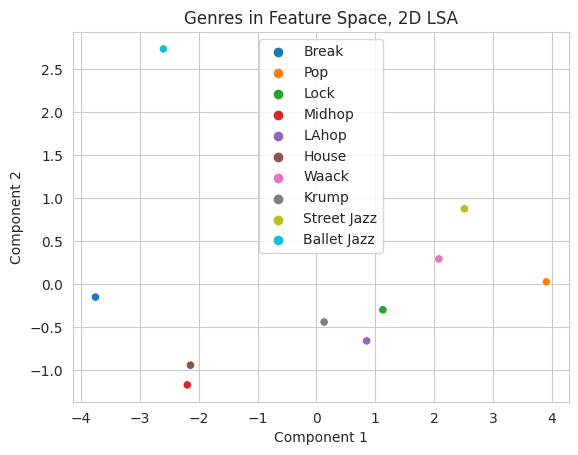

In [25]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Transform your dataframe to numpy array
X = genresbyfeatures.to_numpy()

# Create an LSA (Truncated SVD) object
lsa = TruncatedSVD(n_components=2, n_iter=7, random_state=42)

# Fit the LSA model on the data and transform the data
X_lsa = lsa.fit_transform(X)

# Create a dataframe with the two components
df_lsa = pd.DataFrame(X_lsa, index=genresbyfeatures.index, columns=["Component 1", "Component 2"])

# Plot the two components
sns.scatterplot(data=df_lsa, x="Component 1", y="Component 2", hue=df_lsa.index)
plt.title('Genres in Feature Space, 2D LSA')
plt.savefig('../plots/genres_in_feature_space_LSA.png')
plt.show()


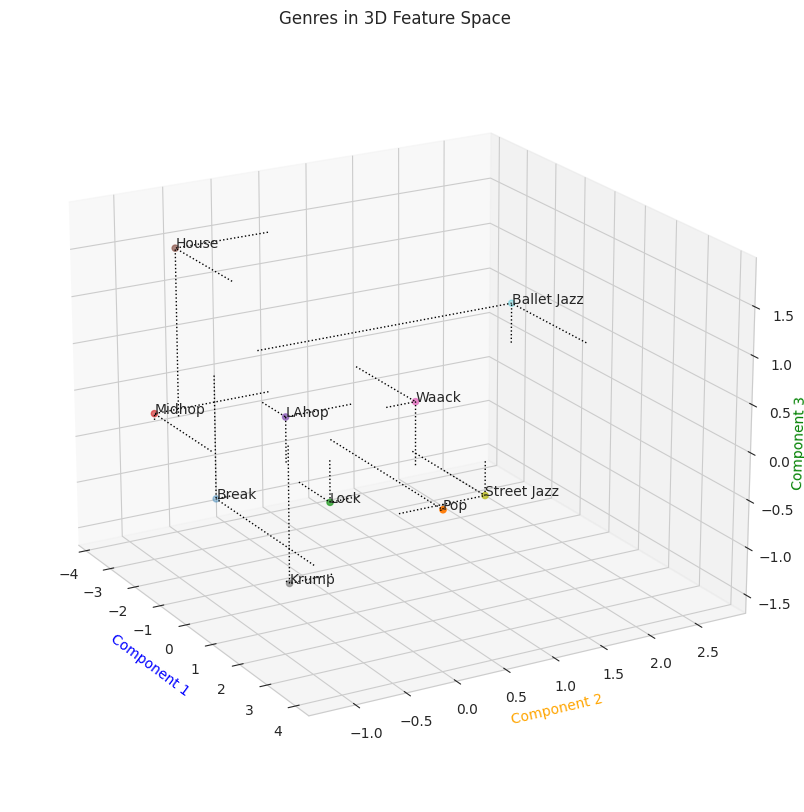

In [43]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Transform your dataframe to numpy array
X = genresbyfeatures.to_numpy()

# Create an LSA (Truncated SVD) object
lsa = TruncatedSVD(n_components=3, n_iter=7, random_state=42)

# Fit the LSA model on the data and transform the data
X_lsa = lsa.fit_transform(X)

# Create a dataframe with the three components
df_lsa = pd.DataFrame(X_lsa, index=genresbyfeatures.index, columns=["Component 1", "Component 2", "Component 3"])

# Create a 3D scatterplot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_lsa['Component 1'], df_lsa['Component 2'], df_lsa['Component 3'], 
                     c=np.arange(len(df_lsa)), cmap='tab10')

# Adding labels and lines
for i, txt in enumerate(df_lsa.index):
    ax.text(df_lsa['Component 1'].iloc[i], df_lsa['Component 2'].iloc[i], df_lsa['Component 3'].iloc[i], txt)
    ax.plot([df_lsa['Component 1'].iloc[i], df_lsa['Component 1'].iloc[i]], 
            [df_lsa['Component 2'].iloc[i], df_lsa['Component 2'].iloc[i]], 
            [0, df_lsa['Component 3'].iloc[i]], 'k:', linewidth=1)

    ax.plot([df_lsa['Component 1'].iloc[i], df_lsa['Component 1'].iloc[i]], 
            [0, df_lsa['Component 2'].iloc[i]], 
            [df_lsa['Component 3'].iloc[i], df_lsa['Component 3'].iloc[i]], 'k:', linewidth=1)

    ax.plot([0, df_lsa['Component 1'].iloc[i]], 
            [df_lsa['Component 2'].iloc[i], df_lsa['Component 2'].iloc[i]], 
            [df_lsa['Component 3'].iloc[i], df_lsa['Component 3'].iloc[i]], 'k:', linewidth=1)

ax.set_title('Genres in 3D Feature Space')

# Change color of axes labels
ax.set_xlabel('Component 1', color='blue')
ax.set_ylabel('Component 2', color='orange')
ax.set_zlabel('Component 3', color='green', labelpad=-1)

# Change the view angle 
ax.view_init(elev=20, azim=-30)

plt.show()


component 1 =? bounciness, 2=? slowflow 3 =? even-tempo

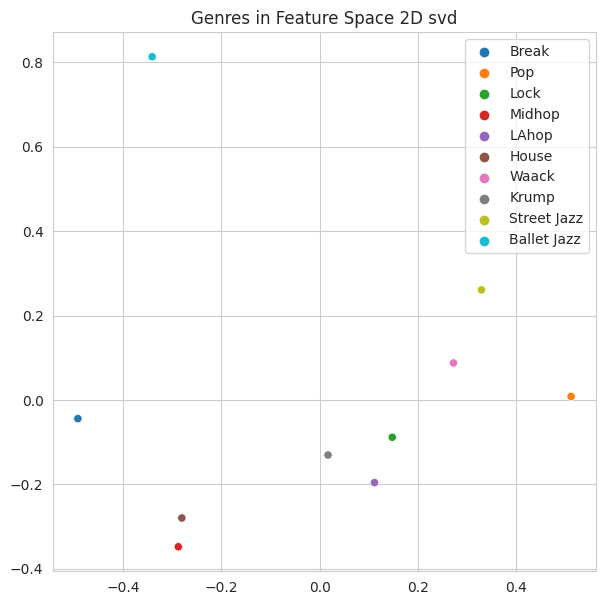

In [24]:
from sklearn.utils.extmath import randomized_svd
X = genresbyfeatures.to_numpy().astype(float)
U, Sigma, VT = randomized_svd(X, n_components=2, n_iter=5, random_state=None)

#plot genres in the 2d feature space
sns.set_style('whitegrid')
plt.figure(figsize=(7,7))
sns.scatterplot(data=genresbyfeatures, x=U[:,0], y=U[:,1], hue=genresbyfeatures.index)
plt.title('Genres in Feature Space 2D svd')
plt.savefig('../plots/featurespace.png')
plt.show()

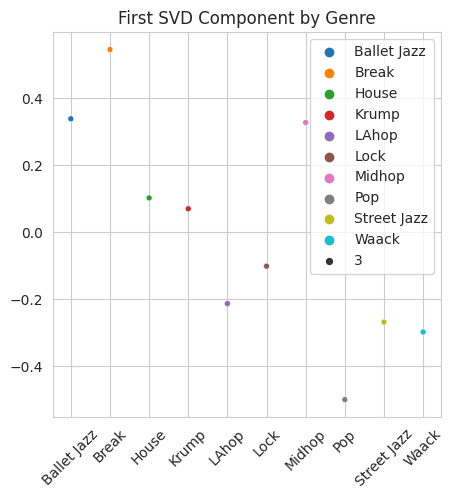

In [100]:
#scatter plot of first SVD component on y axis, dance genre on X axis
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.scatterplot(data=genresbyfeatures, x=genresbyfeatures.index, y=U[:,0], hue=genresbyfeatures.index, size=3)
plt.title('First SVD Component by Genre')
plt.xticks(rotation=45)
plt.savefig('../plots/firstSVD.png')
plt.show()

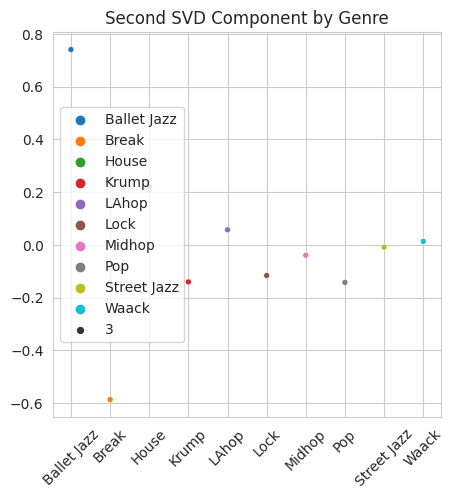

In [99]:
#scatter plot of second SVD component on y axis, dance genre on X axis
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.scatterplot(data=genresbyfeatures, x=genresbyfeatures.index, y=U[:,1], hue=genresbyfeatures.index, size=3)
plt.xticks(rotation=45)
plt.title('Second SVD Component by Genre')
plt.savefig('../plots/secondSVD.png')
plt.show()

Old stuff below here

In [ ]:
#inspect the misclassified Ballet Jazz pieces
yprob_misBJazz = BJazzdf[BJazzdf['Ballet Jazz']<0.5]
yprob_misBJazz

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.102943,0.155679,0.018298,0.104901,0.062415,0.314966,0.030880,0.015018,0.108549,0.086350,1565,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.033570,0.023562,0.024930,0.086090,0.024906,0.672489,0.022066,0.014703,0.074809,0.022876,1591,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.052050,0.021557,0.007512,0.013277,0.032721,0.623952,0.007026,0.012608,0.022553,0.206744,1571,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
6,0.079782,0.294858,0.144204,0.030350,0.121908,0.044607,0.041026,0.014055,0.115876,0.113333,1567,Ballet Jazz,gJB_sFM_cAll_d08_mJB0_ch08


In [ ]:
#Create Dance object for Ballet Jazz pieces that were correctly, and incorrectly classified
HitBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

print(len(HitBJazz)) 

#get Dance object for all Ballet Jazz pieces that were misclassified
missBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in yprob_misBJazz.id.values:
        print(data[-1])
        missBJazz.append(Dance(data[0], dt=1/60))
        missBJazz[-1].get_features()

print(len(missBJazz))
print(missBJazz[0])
print(missBJazz[0].acceleration.shape)

6
gJB_sFM_cAll_d07_mJB4_ch05
gJB_sFM_cAll_d08_mJB0_ch08
gJB_sFM_cAll_d09_mJB3_ch18
gJB_sFM_cAll_d09_mJB2_ch17
4
(15, 1919, 3)


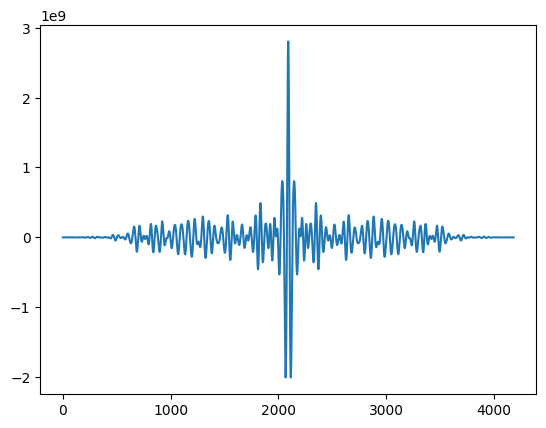

In [17]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first misclassified Ballet Jazz piece
anklecorry_jer = (np.correlate(missBJazz[0].jerk[13][:,1], missBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(missBJazz[0].jerk[14][:,1], missBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

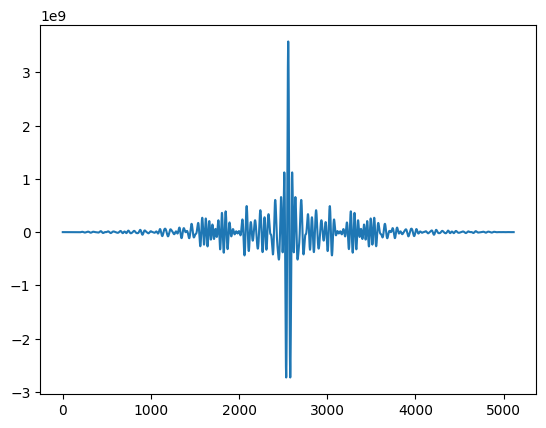

In [20]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first correctly classified Ballet Jazz piece
anklecorry_jer = (np.correlate(HitBJazz[0].jerk[13][:,1], HitBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(HitBJazz[0].jerk[14][:,1], HitBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

In [25]:
#look at the features of the misclassified Ballet Jazz pieces
testset.loc[testset.id.isin(yprob_misBJazz.id)]

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1609,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1583,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1579,1016.357632,99.647915,1285.371478,587.623914,5784.954412,2807.437497,2195.687077,1578.601247,1954.705135,6.754464,...,9.035397e+08,7.964862e+08,8.472218e+07,1.002533e+09,1.734618e+09,1.686987e+09,1.495129e+09,1.035124e+08,gJB_sFM_cAll_d08_mJB3_ch11,Ballet Jazz
1587,1048.961981,107.692128,1234.471461,737.767102,5619.424194,3698.488138,9465.520424,-1080.890634,1052.127688,34.725294,...,1.543689e+09,1.448671e+09,5.126360e+07,4.751784e+08,1.018493e+09,8.528029e+08,7.857072e+08,9.783448e+07,gJB_sFM_cAll_d08_mJB1_ch09,Ballet Jazz
